In [13]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
os.environ['LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu:'

In [14]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

In [15]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [17]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [19]:
model = Sequential()
model.add(Dense(4, input_shape=(16,)))

In [20]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [21]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_single_dense/hls4ml_prj',
                                                       backend= 'VivadoAccelerator',
                                                       part = 'xc7vx690t-3ffg1930'
                                                       )

Interpreting Sequential
Topology:
Layer name: dense_1_input, layer type: Input
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
-----------------------------------
Configuration
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
-----------------------------------
Interpreting Sequential
Topology:
Layer name: dense_1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 4]
Creating HLS model


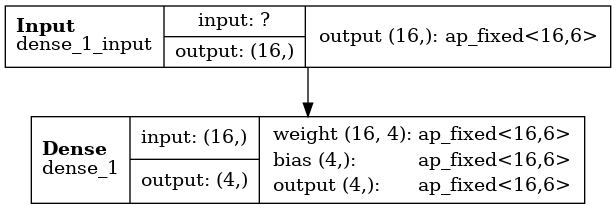

In [22]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [27]:
hls_model.build(csim=True, vsynth=True, cosim=True)

{'CSimResults': [['{', 'data:', '0,', 'last:', '0', '}'],
  ['{', 'data:', '0,', 'last:', '0', '}'],
  ['{', 'data:', '0,', 'last:', '0', '}'],
  ['{', 'data:', '0,', 'last:', '1', '}'],
  []],
 'CosimResults': [['{', 'data:', '0,', 'last:', '0', '}'],
  ['{', 'data:', '0,', 'last:', '0', '}'],
  ['{', 'data:', '0,', 'last:', '0', '}'],
  ['{', 'data:', '0,', 'last:', '1', '}'],
  []],
 'EstimatedClockPeriod': '4.367',
 'BestLatency': '45',
 'WorstLatency': '45',
 'IntervalMin': '46',
 'IntervalMax': '46',
 'BRAM_18K': '0',
 'DSP48E': '50',
 'FF': '8854',
 'LUT': '8013',
 'URAM': '0',
 'AvailableBRAM_18K': '280',
 'AvailableDSP48E': '220',
 'AvailableFF': '106400',
 'AvailableLUT': '53200',
 'AvailableURAM': '0',
 'CosimRTL': 'Verilog',
 'CosimStatus': 'Pass',
 'CosimLatencyMin': '44',
 'CosimLatencyMax': '44',
 'CosimIntervalMin': 'NA',
 'CosimIntervalMax': 'NA'}

In [26]:
hls4ml.report.read_vivado_report('model_single_dense/hls4ml_prj/')

Found 1 solution(s) in model_single_dense/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
make: 'csim.exe' is up to date.
INFO: Unable to open input/predictions file, using default input.
{ data: 0, last: 0 }
 { data: 0, last: 0 }
 { data: 0, last: 0 }
 { data: 0, last: 1 }
 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Tue Dec 21 12:06:00 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Targ

In [24]:
%cd /home/li/vivadohls/model_single_dense/hls4ml_prj
! vivado -mode batch -source vivado_synth.tcl

/home/li/vivadohls/model_single_dense/hls4ml_prj

****** Vivado v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source vivado_synth.tcl
# proc dump_statistics {  } {
#   set util_rpt [report_utilization -return_string]
#   set LUTFFPairs 0
#   set SliceRegisters 0
#   set Slice 0
#   set SliceLUTs 0
#   set SliceLUTs1 0
#   set BRAMFIFO36 0
#   set BRAMFIFO18 0
#   set BRAMFIFO36_star 0
#   set BRAMFIFO18_star 0
#   set BRAM18 0
#   set BRAMFIFO 0
#   set BIOB 0
#   set DSPs 0
#   set TotPower 0
#   set design_slack 0
#   set design_req 0
#   set design_delay 0
#   regexp --  {\s*LUT Flip Flop Pairs\s*\|\s*([^[:blank:]]+)} $util_rpt ignore LUTFFPairs
#   regexp --  {\s*Slice Registers\s*\|\s*([^[:blank:]]+)} $util_rpt ignore SliceRegisters
#   regexp --  {\s*Slice\s*\|\s*([^[:blank:]]+)} $util_rpt ignore Slice
#   regexp --  {\s*Slice LUTs\s*\|\

In [28]:
hls4ml.templates.VivadoAcceleratorBackend.make_bitfile(hls_model)